In [1]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# step 1
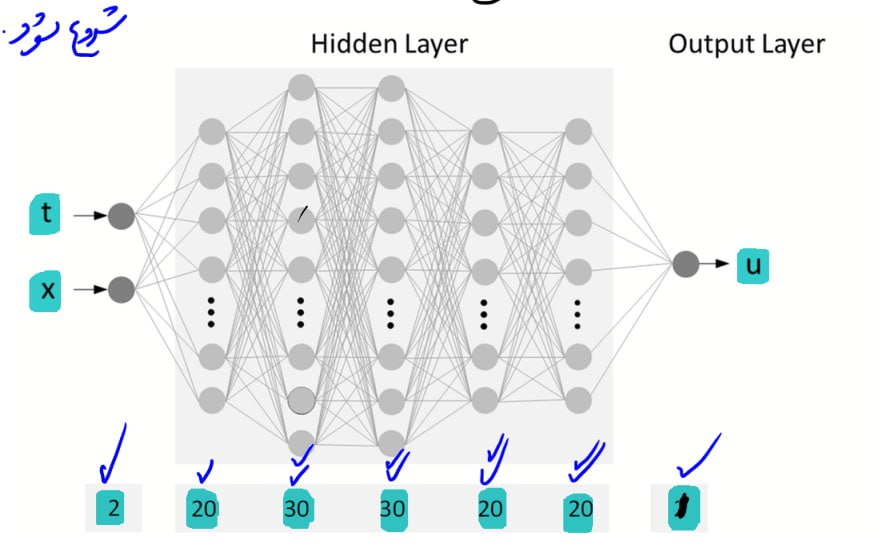

In [2]:
#structure of NN
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )

    def forward(self,x):
        out=self.net(x)
        return out

# step 2

In [3]:
# define the class Net
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model=NN().to(device)

#computational domain
        self.h=0.1
        self.k=0.1
        x=torch.arange(-1,1+self.h,self.h)
        t=torch.arange(0,1+self.h,self.h)

        self.X = torch.stack(torch.meshgrid(x, t, indexing='ij')).reshape(2, -1).T

#train data
        bc1=torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2=torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic=torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train=torch.cat([bc1,bc2,ic])

        y_bc1=torch.zeros(len(bc1))
        y_bc2=torch.zeros(len(bc2))
        y_ic=-torch.sin(math.pi*ic[:,0])
        self.y_train=torch.cat([y_bc1,y_bc2,y_ic])
        self.y_train=self.y_train.unsqueeze(1)

        self.X=self.X.to(device)
        self.y_train=self.y_train.to(device)
        self.X_train=self.X_train.to(device)
        self.X.requires_grad=True

#optimizer setting
        self.adam=torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer=torch.optim.LBFGS(self.model.parameters(),
                                        lr=1.0,
                                        max_iter=50000,
                                        max_eval=50000,
                                        history_size=50,
                                        tolerance_grad=1e-7,
                                        tolerance_change=1.0*np.finfo(float).eps,
                                        line_search_fn='strong_wolfe'
                                        )
        
        self.criterion=torch.nn.MSELoss()
        self.iter=1
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred=self.model(self.X_train)
        loss_data=self.criterion(y_pred,self.y_train)

        u=self.model(self.X)
        du_dX=torch.autograd.grad(
            u,
            self.X,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]

        du_dt=du_dX[:,1]
        du_dx=du_dX[:,0]

        du_dXX=torch.autograd.grad(
            u,
            self.X,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        du_dxx=du_dXX[:,0]

        loss_pde=self.criterion(du_dt+u.unsqueeze(1)*du_dx,(0.01/math.pi)*du_dxx)

        loss=loss_pde+loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter,loss.item())
        self.iter += 1

        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()
        

In [4]:
# Training
net=Net()
net.train()

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([231])) that is different to the input size (torch.Size([231, 1, 231])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


100 0.16166989505290985
200 0.11848041415214539
300 0.1172981709241867
400 0.11690811812877655
500 0.11671583354473114
600 0.11640472710132599
700 0.11627405881881714
800 0.11621016263961792
900 0.11613371968269348
1000 0.11608807742595673


In [5]:
#Evaluation
net.model.eval()

h=0.01
k=0.01

x=torch.arange(-1,1,h)
t=torch.arange(0,1,k)

X=torch.stack(torch.meshgrid(x, t, indexing='ij')).reshape(2, -1).T
X=X.to(net.X.device)

model=net.model
model.eval()
with torch.no_grad():
    y_pred=model(X)
    y_pred=y_pred.reshape(len(x),len(t)).cpu().numpy()

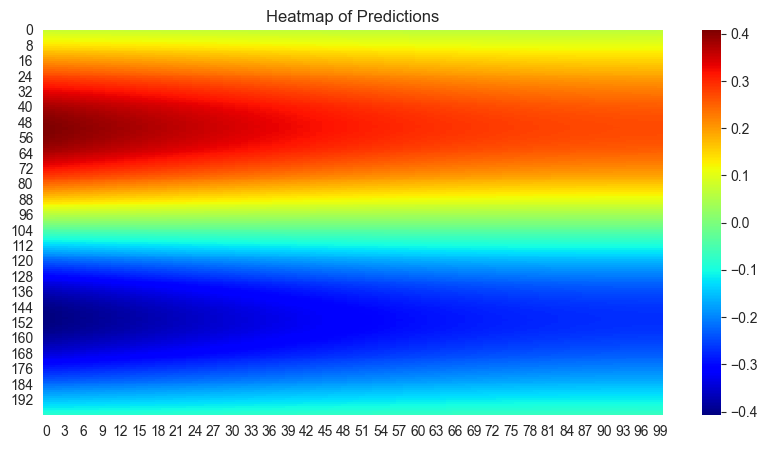

Text(0.5, 1.0, 't=99')

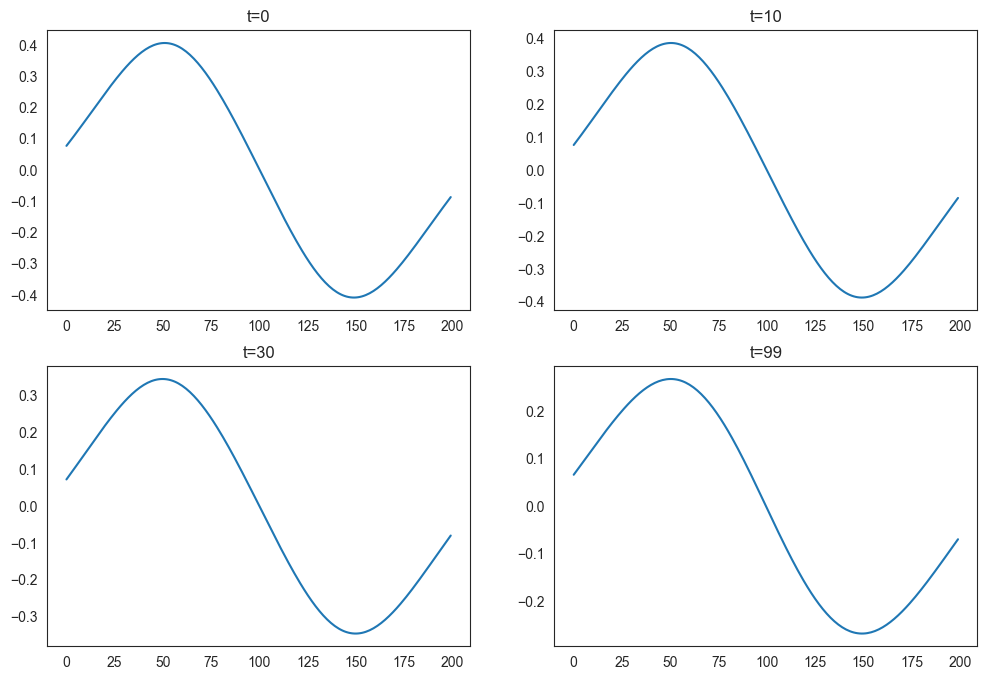

In [6]:
#plot the result
sns.set_style("white")
plt.figure(figsize=(10, 5)) 
sns.heatmap(y_pred, cmap='jet')
plt.title('Heatmap of Predictions')
plt.show() 


plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.plot(y_pred[:,0])
plt.title('t=0')

plt.subplot(2,2,2)
plt.plot(y_pred[:,10])
plt.title('t=10')

plt.subplot(2,2,3)
plt.plot(y_pred[:,30])
plt.title('t=30')

plt.subplot(2,2,4)
plt.plot(y_pred[:,99])
plt.title('t=99')